In [8]:
#pandas
import pandas as pd
from pandas import Series,DataFrame

#numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from datetime import datetime
import math
from sklearn.preprocessing import LabelEncoder
#machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,accuracy_score,mean_squared_log_error
from sklearn.metrics import roc_curve, auc,roc_auc_score,mean_squared_error
import xgboost as xgb
from numpy.linalg import inv
from xgboost.sklearn import XGBClassifier
from sklearn.kernel_ridge import KernelRidge
import matplotlib.dates
import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3
import missingno as msno

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


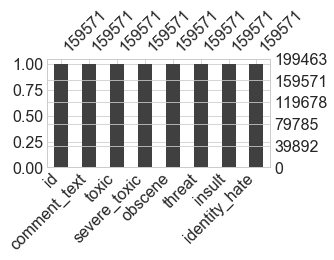

In [5]:
msno.bar(train,sort = True,figsize=(4,2))

In [18]:
for col in train.columns:
    if(col != 'id' and col!= 'comment_text'):
        print(col , " " , train[col].value_counts())

toxic   0    144277
1     15294
Name: toxic, dtype: int64
severe_toxic   0    157976
1      1595
Name: severe_toxic, dtype: int64
obscene   0    151122
1      8449
Name: obscene, dtype: int64
threat   0    159093
1       478
Name: threat, dtype: int64
insult   0    151694
1      7877
Name: insult, dtype: int64
identity_hate   0    158166
1      1405
Name: identity_hate, dtype: int64


In [19]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [24]:
train['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [15]:
train['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [11]:
topics = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
y = train[topics].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

In [12]:
def tokenise_sentence(list_sentence):
    max_features = 20000
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(list_sentence))
    tokenized_sentence = tokenizer.texts_to_sequences(list_sentence)
    return tokenized_sentence

In [13]:
list_tokenized_train = tokenise_sentence(list_sentences_train)
list_tokenized_test = tokenise_sentence(list_sentences_test)

In [9]:
max_len = 0
min_len = 1500
for sentence in list_tokenized_train:
    max_len = np.maximum(max_len,len(sentence))
    if(len(sentence)!=0 and len(sentence)!=1):
        min_len = np.minimum(min_len,len(sentence))
print(max_len)
print(min_len)


1400
2


In [14]:
sentence_len = []
for sentence in list_tokenized_train:
    sentence_len.append(len(sentence))
sen = pd.DataFrame()
sen['sentence_len'] =  sentence_len

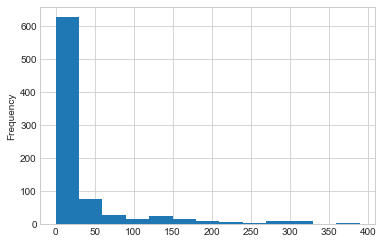

In [15]:
sen['sentence_len'].value_counts().plot(kind = 'hist',bins = np.arange(0,410,30))

In [11]:
sen['sentence_len'].value_counts().plot

In [12]:
index =0 
for sentence in list_tokenized_train:
    if(len(sentence) == 0):
        print(index)
    index+=1

21913
32603
32768
37372
37604
38194
53213
54528
58392
63579
64932
68846
83127
86550
87083
97243
106407
109985
111612
120025
129656
134407
140223
143273


In [16]:
max_len_for_padding = 200
X_train = pad_sequences(list_tokenized_train,maxlen=max_len_for_padding)
X_test = pad_sequences(list_tokenized_test,maxlen=max_len_for_padding)

In [17]:
max_features = 20000

In [18]:

inp = Input(shape=(max_len_for_padding,))
embed_size = 128
x = Embedding(max_features,embed_size)(inp)
x = Bidirectional(LSTM(60,return_sequences=True,name = 'lstm_layer_1'))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6,activation='sigmoid')(x)
model = Model(inputs=inp,outputs=x)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])


In [19]:
batch_size = 32
epochs = 2
model.fit(X_train,y,batch_size=batch_size,epochs=epochs,validation_split=0.1)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 143613 samples, validate on 15958 samples
Epoch 1/2
124448/143613 [========================>.....] - ETA: 3:27 - loss: 0.0747 - acc: 0.9757

KeyboardInterrupt: 

In [ ]:
model.fit?

In [93]:
y_test = model.predict(X_test,batch_size=1024,verbose=1)

153164/153164 [==============================] - 191s 1ms/step


In [80]:
y_test[0]

array([ 0.6517269 ,  0.02130032,  0.53526521,  0.01925105,  0.34009022,
        0.04627606], dtype=float32)

In [94]:
hamse_na_ho_payega = test[['id']]

In [95]:
i = 0
for topic in topics:
    hamse_na_ho_payega[topic] = y_test[:,i]
    i+=1

In [96]:
hamse_na_ho_payega.to_csv('hamse_na_ho_payega.csv',index=False)